In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import yaml
import os
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import openslide

from wsi.slide import downsample
from wsi.slide import thumbnail
from wsi.patch import get_slide_patches_params, patch_slide
from wsi.filter import *

from utils import display_image_array

from IPython.display import display 

In [47]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

**Config**

In [48]:
MAGNIFICATION = 2.5
PATCH_SIZE = 128
BLANK_PIXEL_THRESHOLD = 30

THUMBNAIL_SIZE = 1024
DISPLAY_SIZE = (400, 400)

In [49]:
slides_path = os.path.join(conf['data_path'], 'slides', 'svs')

In [50]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')

if not os.path.exists(patches_path):
    os.mkdir(patches_path)

In [51]:
thumbnails_path = os.path.join(conf['data_path'], 'slides', 'thumbnail')

if not os.path.exists(thumbnails_path):
    os.mkdir(thumbnails_path)

In [52]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')
slides_df = slides_df[slides_df['file_name'].isin(os.listdir(slides_path))]

In [53]:
slides_df.head(2)

,file_id,case_id,sample_id,slide_id,data_type,experimental_strategy,data_format,file_size,file_name,primary_site,disease_type,sample_type,is_ffpe,percent_normal_cells,percent_stromal_cells,percent_tumor_cells,percent_tumor_nuclei
1,7ec5c9d0-8c22-4e30-bae8-605c3dcfe744,TCGA-HZ-A49I,TCGA-HZ-A49I-01A,TCGA-HZ-A49I-01A-01-TS1,Slide Image,Tissue Slide,SVS,293.72,TCGA-HZ-A49I-01A-01-TS1.svs,Pancreas,Ductal and Lobular Neoplasms,Primary Tumor,False,40.0,55.0,5.0,5.0
2,265adb6b-913e-490c-8cea-32d67c1440a2,TCGA-3A-A9IZ,TCGA-3A-A9IZ-01A,TCGA-3A-A9IZ-01A-01-TS1,Slide Image,Tissue Slide,SVS,166.95,TCGA-3A-A9IZ-01A-01-TS1.svs,Pancreas,Ductal and Lobular Neoplasms,Primary Tumor,False,25.0,0.0,65.0,40.0


## Save slide thumbnails

In [95]:
for file in tqdm(slides_df['file_name'].values, unit='file'):
    
    os_img = openslide.open_slide(os.path.join(slides_path, file))
    img = thumbnail(os_img, max_size=THUMBNAIL_SIZE)
    
    img.save(os.path.join(thumbnails_path, file.replace('.svs', '.png')))

## Patching

In [29]:
slides_path

'/Users/portizdegalisteo/TFM_Data/slides/svs'

In [124]:
results = []

for slide_file in tqdm(slides_df['file_name'].values):
        
    os_img = openslide.open_slide(os.path.join(slides_path, slide_file))
    n_patches, n_valid_patches = patch_slide(os_img, patches_path, PATCH_SIZE, MAGNIFICATION)
    
    results.append({'file': file, 'total_patches': n_patches, 'valid_patches': n_valid_patches, 
                    'perc_valid_patches': round(n_valid_patches / n_patches, 2)})
    
results = pd.DataFrame(results)

In [54]:
files = os.listdir(slides_path)
file= files[89]
file

'TCGA-IB-A5ST-01A-01-TSA.svs'

In [126]:
results['valid_patches'].sum()

22947

In [55]:
file = [x for x in files if '6880' in x][1]

In [56]:
os_img = openslide.open_slide(os.path.join(slides_path, file))

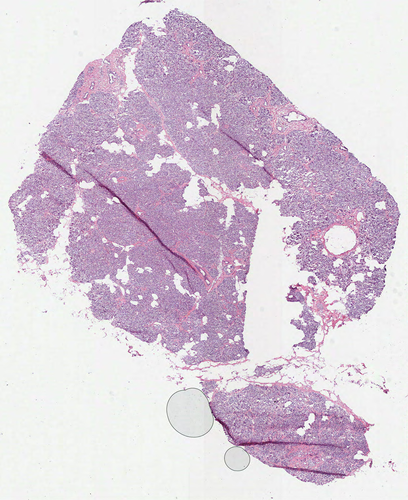

In [57]:
thumbnail(os_img, max_size=500)

In [58]:
os_img.level_downsamples

(1.0, 4.000131908719166, 16.001583113456462)

In [59]:
os_img.level_dimensions

((24752, 30326), (6188, 7581), (1547, 1895))

In [60]:
levels_magnification = [int(os_img.properties['aperio.AppMag'])/int(x) for x in os_img.level_downsamples]
levels_magnification

[40.0, 10.0, 2.5]

In [61]:
save_slide_patches(os.path.join(slides_path, file), patches_path, 
                   patch_size=PATCH_SIZE, magnification=MAGNIFICATION)

True

In [62]:
patches_params = get_slide_patches_params(os_img, PATCH_SIZE, MAGNIFICATION)

In [63]:
import random

In [73]:
patch_params  = random.choice(patches_params)
patch_params

{'index': (8, 5),
 'location': [10241, 16385],
 'level': 2,
 'level_patch_size': (128, 128),
 'patch_size': (128, 128),
 'resize': 1.0}

In [74]:
patch_img = os_img.read_region(patch_params['location'], patch_params['level'], patch_params['level_patch_size'])

In [75]:
patch_arr = np.asarray(patch_img.convert('RGB'))

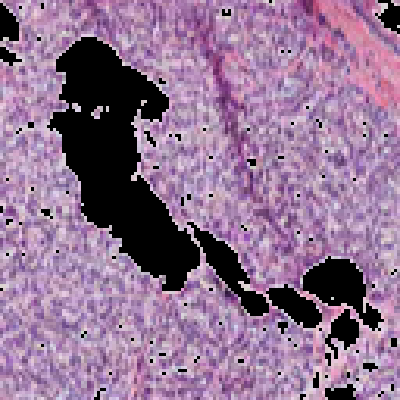

In [113]:
Image.fromarray(patch_arr).resize(DISPLAY_SIZE)

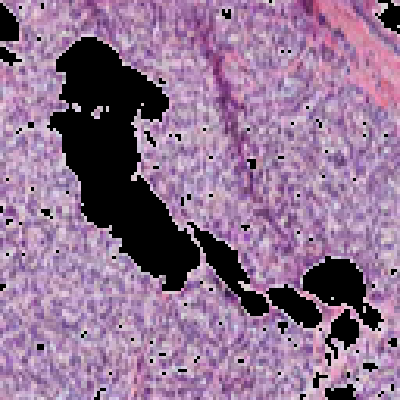

In [112]:
patch_arr_filt = filter_greys(patch_arr, tolerance=20, reverse=False)
Image.fromarray(patch_arr_filt).resize(DISPLAY_SIZE)

(180, 58)

For all slides

In [120]:
results = []

for file in tqdm(files): 
    

TypeError: open_slide() missing 1 required positional argument: 'filename'

**Read**

## Tests

In [103]:
import openslide
from tqdm import tqdm_notebook as tqdm

In [104]:
slides_info = []

In [105]:
for slide_file in tqdm(os.listdir(slides_path)):
    
    if slide_file == 'Icon\r':
        continue
        
    slide_img = openslide.open_slide(os.path.join(slides_path, slide_file))
    
    slide_info = {'file': slide_file}
    
    slide_info['magnification'] = slide_img.properties['aperio.AppMag']
    slide_info['n_levels'] = slide_img.level_count
    w,h = slide_img.dimensions
    slide_info['height'] = h
    slide_info['width'] = w
    
    for i,dim in enumerate(slide_img.level_dimensions):
        w,h = dim
        slide_info['height_' + str(i)] = h
        slide_info['width_' + str(i)] = w
        
    slides_info.append(slide_info)

In [106]:
slide_info = pd.DataFrame(slides_info)

In [109]:
slide_info[['file', 'height', 'width', 'magnification', 'n_levels', 
            'height_0', 'width_0', 'height_1', 'width_1', 'height_2', 'width_2', 'height_3', 'width_3',]].to_csv('slides_summary.csv', index=False, sep='|')

In [110]:
slide_info.groupby(['n_levels', 'magnification']).size()

n_levels  magnification
2         20                 2
3         20                11
          40                51
4         40               145
dtype: int64

In [119]:
slide_info

,file,height,height_0,height_1,height_2,height_3,magnification,n_levels,width,width_0,width_1,width_2,width_3
0,TCGA-IB-7887-01A-01-BS1.svs,63714,63714,15928,3982.0,1991.0,40,4,52360,52360,13090,3272.0,1636.0
1,TCGA-HZ-A9TJ-01A-01-TS1.svs,32756,32756,8189,2047.0,1023.0,40,4,101591,101591,25397,6349.0,3174.0
2,TCGA-HZ-A8P0-01A-01-TS1.svs,24684,24684,6171,1542.0,771.0,40,4,91631,91631,22907,5726.0,2863.0
3,TCGA-H6-A45N-01A-01-TS1.svs,21094,21094,5273,1318.0,659.0,40,4,99959,99959,24989,6247.0,3123.0
4,TCGA-FB-AAPY-01A-01-TS1.svs,41478,41478,10369,2592.0,1296.0,40,4,99599,99599,24899,6224.0,3112.0
5,TCGA-HV-A5A4-01A-01-TS1.svs,19962,19962,4990,1247.0,NaN,40,3,58412,58412,14603,3650.0,NaN
6,TCGA-F2-7276-01A-01-TS1.svs,11826,11826,2956,NaN,NaN,20,2,16308,16308,4077,NaN,NaN
7,TCGA-HZ-8315-01A-01-TS1.svs,49952,49952,12488,3122.0,1561.0,40,4,29880,29880,7470,1867.0,933.0
8,TCGA-IB-A5SQ-01A-01-TSA.svs,23390,23390,5847,1461.0,730.0,40,4,105672,105672,26418,6604.0,3302.0
9,TCGA-2J-AABP-01A-01-TS1.svs,29033,29033,7258,1814.0,907.0,40,4,93624,93624,23406,5851.0,2925.0
